In [1]:
import os
import sys
sys.path.insert(0, os.path.realpath('__file__'))

import FLife
import lvm_read
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as si
from scipy.integrate import quad

Read the time-history data from file m1.lvm

In [2]:
data = lvm_read.read('./data/m1.lvm')[0]
t = data['data'][:,0]
x = data['data'][:,1]

Set parameters for fatigue-life estimation and scale the time signal

In [3]:
rms = 100  
C = 1.8e+19
k = 6
Su = 446
x = rms * x / np.std(x) 

Instantiate an object of type spectralData and depict PSD and peak amplitude PDF

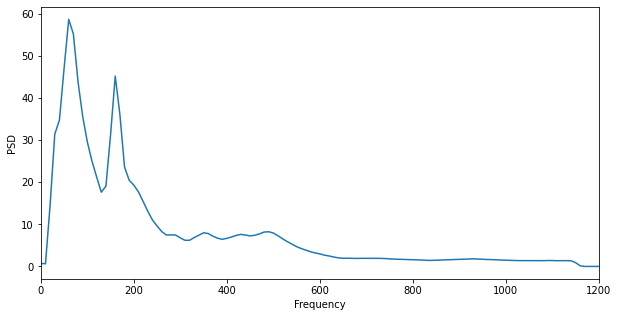

In [4]:
sd = FLife.SpectralData(input=(x, t[1]), nperseg=int(0.1/t[1]))

plt.figure(figsize=(10,5))
plt.plot(sd.psd[:,0],sd.psd[:,1])
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.xlim(0,1200)
plt.show()

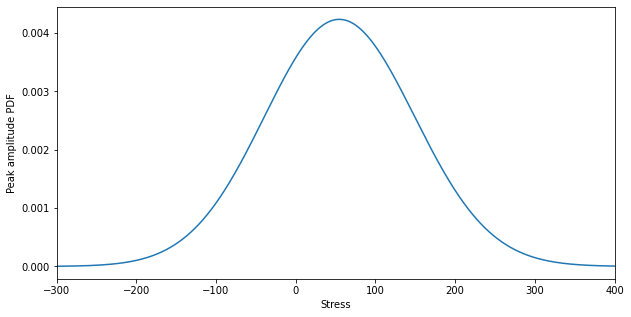

In [5]:
s_rice = np.arange(np.min(sd.data), np.max(sd.data), 0.1)

plt.figure(figsize=(10,5))
plt.plot(s_rice, sd.get_peak_PDF(s_rice))
plt.xlabel('Stress')
plt.ylabel('Peak amplitude PDF')
plt.xlim(-300,400)
plt.show()

Instantiation of Fatigue-Life estimation method objects, including Rainflow counting cycle algorithm as reference

In [33]:
# Rainflow reference fatigue life
rf = FLife.Rainflow(sd)

# Spectral methods
nb = FLife.Narrowband(sd)
wl = FLife.WirschingLight(sd)
oc = FLife.OrtizChen(sd)
a075 = FLife.Alpha075(sd)
tb = FLife.TovoBenasciutti(sd)
dirlik = FLife.Dirlik(sd)
zb = FLife.ZhaoBaker(sd)
park = FLife.Park(sd)
jm = FLife.JiaoMoan(sd)
so = FLife.SakaiOkamura(sd)
fc = FLife.FuCebon(sd)
mfc = FLife.ModifiedFuCebon(sd)
low = FLife.Low(sd)
gm = FLife.GaoMoan(sd)
sm = FLife.SingleMoment(sd)
bm = FLife.BandsMethod(sd)

Check PSD splitting method: equalAreaBands and userDefinedBands

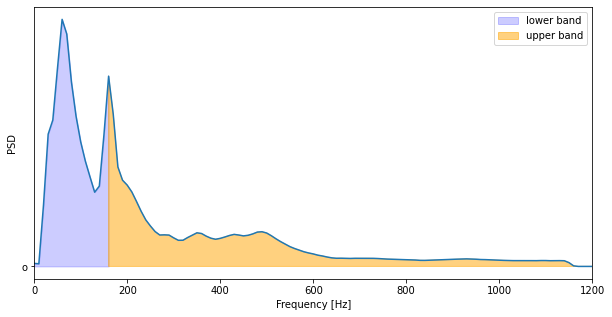

In [34]:
#for Jiao-Moan method, default is `PSD_splitting` = ('equalAreaBands', 2)
lower_band_index, upper_band_index= jm.band_stop_indexes

plt.figure(figsize=(10,5))
plt.plot(sd.psd[:,0], sd.psd[:,1])
plt.fill_between(sd.psd[:lower_band_index+1,0], sd.psd[:lower_band_index+1,1], 'o', label='lower band', alpha=.2, color='blue')
plt.fill_between(sd.psd[lower_band_index:upper_band_index+1,0], sd.psd[lower_band_index:upper_band_index+1,1], 'o', label='upper band', alpha=.5, color ='orange')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim(0,1200)
plt.legend();

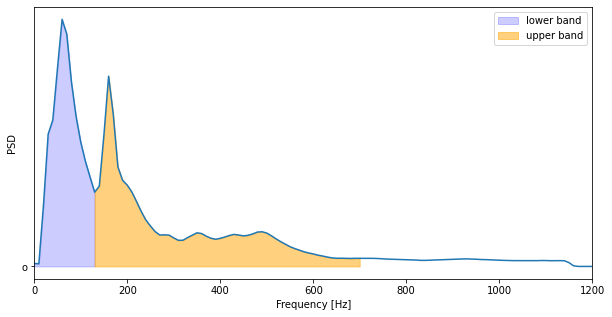

In [47]:
#user defined bands 
jm_userDefinedBands = FLife.JiaoMoan(sd, PSD_splitting = ('userDefinedBands', [130, 700]))
lower_band_index, upper_band_index= jm_userDefinedBands.band_stop_indexes

plt.figure(figsize=(10,5))
plt.plot(sd.psd[:,0], sd.psd[:,1])
plt.fill_between(sd.psd[:lower_band_index+1,0], sd.psd[:lower_band_index+1,1], 'o', label='lower band', alpha=.2, color='blue')
plt.fill_between(sd.psd[lower_band_index:upper_band_index+1,0], sd.psd[lower_band_index:upper_band_index+1,1], 'o', label='upper band', alpha=.5, color ='orange')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim(0,1200)
plt.legend();

Define stress vector and depict stress cycle amplitude PDF

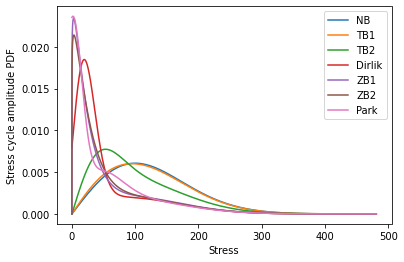

Integrals of PDF should be 1!
         Narrowband:     1
 Tovo Benasciutti 1:     1
 Tovo Benasciutti 2:     1
             Dirlik:     1
       Zhao Baker 1:     1
       Zhao Baker 2:     1
               Park:     1


In [48]:
s = np.arange(0,np.max(x),.001)

#Show PDF functions
plt.plot(s,nb.get_PDF(s), label='NB')
plt.plot(s,tb.get_PDF(s, method='method 1'), label='TB1')
plt.plot(s,tb.get_PDF(s, method='method 2'), label='TB2')
plt.plot(s,dirlik.get_PDF(s), label='Dirlik')
plt.plot(s,zb.get_PDF(s, method='method 1'), label='ZB1')
plt.plot(s,zb.get_PDF(s, method='method 2'), label='ZB2')
plt.plot(s,park.get_PDF(s), label='Park')
plt.xlabel('Stress')
plt.ylabel('Stress cycle amplitude PDF')
plt.legend()
plt.show()


#Integral of PDF should be 1!
PDFs = {
    'Narrowband': quad(nb.get_PDF, a=0, b=np.Inf)[0],
    'Tovo Benasciutti 1': quad(tb.get_PDF, a=0, b=np.Inf, args=('method 1',))[0],
    'Tovo Benasciutti 2': quad(tb.get_PDF, a=0, b=np.Inf, args=('method 2',))[0],
    'Dirlik': quad(dirlik.get_PDF, a=0, b=np.Inf)[0],
    'Zhao Baker 1': quad(zb.get_PDF, a=0, b=np.Inf, args=('method 1',))[0],
    'Zhao Baker 2': quad(zb.get_PDF, a=0, b=np.Inf, args=('method 2',))[0],
    'Park': quad(park.get_PDF, a=0, b=np.Inf)[0],

}

print('Integrals of PDF should be 1!')
for method, value in PDFs.items():
    print(f'{method:>19s}:{value:6.0f}')


Estimate Fatigue Life via closed-loop expression and PDF integration

In [49]:
results = {
        'Rainflow': rf.get_life(C = C, k=k, algorithm='four-point'),
        'Narrowband': nb.get_life(C = C, k=k),
        'Wirsching Light': wl.get_life(C = C, k=k),
        'Ortiz Chen': oc.get_life(C = C, k=k),
        'Alpha 0.75': a075.get_life(C = C, k=k),
        'Tovo Benasciutti 1': float(tb.get_life(C = C, k=k, method='method 1')),
        'Tovo Benasciutti 2': float(tb.get_life(C = C, k=k)),
        'Dirlik': float(dirlik.get_life(C = C, k=k)),
        'Zhao Baker 1': zb.get_life(C = C, k=k),
        'Zhao Baker 2': zb.get_life(C = C, k=k, method='method 2'),
        'Park': park.get_life(C = C, k=k),
        'Jiao Moan': jm.get_life(C = C, k=k),
        'Jiao Moan userDefinedBands': jm_userDefinedBands.get_life(C = C, k=k),
        'Sakai Okamura': so.get_life(C = C, k=k),
        'Fu Cebon': fc.get_life(C = C, k=k),
        'Modified Fu Cebon': mfc.get_life(C = C, k=k),
        #'Low': low.get_life(C = C, k=int(k)),
        'Gao Moan': gm.get_life(C = C, k=k),
        'Single moment': sm.get_life(C = C, k=k),
        'Bands method': bm.get_life(C = C, k=k)
}


results_via_PDF = {
    'Narrowband': nb.get_life(C = C, k=k, integrate_pdf=True),
    'Tovo Benasciutti 1': tb.get_life(C = C, k=k, method='method 1', integrate_pdf=True),
    'Tovo Benasciutti 2': tb.get_life(C = C, k=k, integrate_pdf=True),
    'Dirlik': dirlik.get_life(C = C, k=k, integrate_pdf=True),
    'Zhao Baker 1': zb.get_life(C = C, k=k, integrate_pdf=True),
    'Zhao Baker 2': zb.get_life(C = C, k=k, method='method 2', integrate_pdf=True),
    'Park': park.get_life(C = C, k=k),
}

print('Comparison of fatigue life')
for k1, v in results.items():
    err = FLife.tools.relative_error(v, results['Rainflow'])
    via_PDF = ''
    if k1 in results_via_PDF:
        via_PDF = f' (via PDF: {results_via_PDF[f"{k1}"]:6.0f} s)'
    print(f'{k1:>19s}:{v:6.0f} s,{100*err:>4.0f} % to {"Rainflow"}{via_PDF}')

Comparison of fatigue life
           Rainflow:  1399 s,   0 % to Rainflow
         Narrowband:  1064 s, -24 % to Rainflow (via PDF:   1064 s)
    Wirsching Light:  1462 s,   4 % to Rainflow
         Ortiz Chen:  1599 s,  14 % to Rainflow
         Alpha 0.75:  1626 s,  16 % to Rainflow
 Tovo Benasciutti 1:  1099 s, -21 % to Rainflow (via PDF:   1100 s)
 Tovo Benasciutti 2:  1657 s,  18 % to Rainflow (via PDF:   1666 s)
             Dirlik:  1595 s,  14 % to Rainflow (via PDF:   1595 s)
       Zhao Baker 1:  1473 s,   5 % to Rainflow (via PDF:   1473 s)
       Zhao Baker 2:  1565 s,  12 % to Rainflow (via PDF:   1565 s)
               Park:  1708 s,  22 % to Rainflow (via PDF:   1708 s)
          Jiao Moan:   813 s, -42 % to Rainflow
Jiao Moan userDefinedBands:  1559 s,  11 % to Rainflow
      Sakai Okamura:  4966 s, 255 % to Rainflow
           Fu Cebon:  1151 s, -18 % to Rainflow
  Modified Fu Cebon:   846 s, -40 % to Rainflow
           Gao Moan:  1310 s,  -6 % to Rainflow
      Sing